## Computing the pitch of a speech frame with the autocorrelation method ##

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.io import wavfile
from scipy.signal import correlate
import numpy as np
import numpy.fft as fft
from scipy.signal import hamming
import matplotlib
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (16, 6)

NameError: name 'y' is not defined

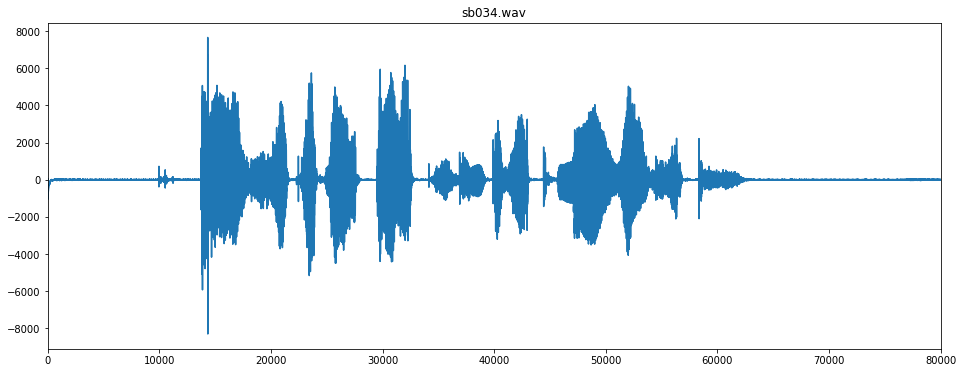

In [3]:
# Read and plot a speech file from the FDA_UE database
from scipy.signal import lfilter
name = "sb034.wav"
filename="../input/fda_ue/" + name
sfreq, data = wavfile.read(filename)
plot(data)
xlim(0, len(data))
title(name)
def noise_cancelling(frame):
    n = 10 # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    frame = lfilter(b,a,frame)
    return frame
y = noise_cancelling(y)
y = y.astype(float)/ 2**12

40960


Text(0.5,1,'A frame')

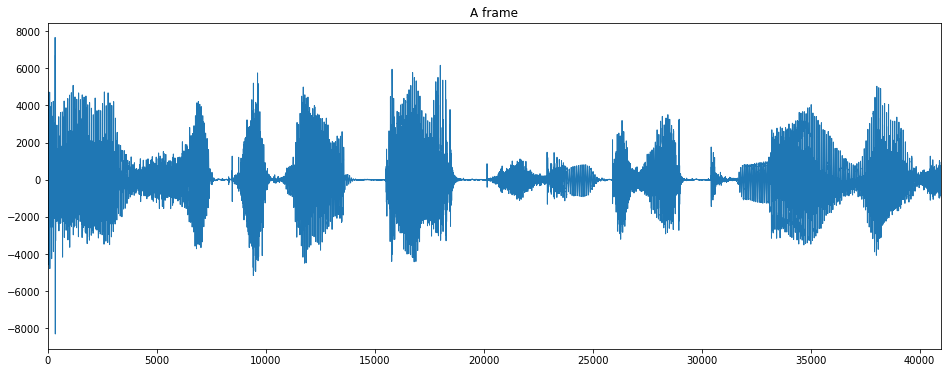

In [4]:
windowlength = 2048# 32ms
ns_windowlength = int(round((windowlength * sfreq) / 1000))
pos = 14000
frame_length = ns_windowlength

frame = data[pos:pos+frame_length]

print(frame_length)
plot(frame, linewidth=1.0)
xlim(0, frame_length)
title("A frame")

In [5]:
# Convert both raw samples and sample rate to floats, then convert stereo to mono.
(fs, y) = wavfile.read(filename)
y = noise_cancelling(y)
#y = y.astype(float) / 2**12 # normalize to -1 to 1
fs = float(fs)

windowlength = 2048# 32ms
ns_windowlength = int(round((windowlength * sfreq) / 1000))
pos = 14000
frame_length = ns_windowlength

frame = y[pos:pos+frame_length]
y = frame

def sliding(x, Nwin, Noverlap=0, f=lambda x: x):
  hop = Nwin - Noverlap
  return [f(x[i : i + Nwin])
          for i in range(0, len(x), hop)
          if i + Nwin <= len(x)]

def hps(x, numProd, Nfft=None, fs=1):

  Nfft = Nfft or x.size
  # Evaluate FFT. f is the frequencies corresponding to the spectrum xf
  f = np.arange(Nfft) / Nfft
  xf = fft.fft(x, Nfft)
  # Keep magnitude of spectrum at positive frequencies
  xf = np.abs(xf[f < 0.5])
  f = f[f < 0.5]
  N = f.size

  # Downsample-multiply
  smallestLength = int(np.ceil(N / numProd))
  y = xf[:smallestLength].copy()
  for i in range(2, numProd + 1):
    y *= xf[::i][:smallestLength]
  f = f[:smallestLength] * fs
  return (y, f)


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [6]:
print(frame_length)

40960


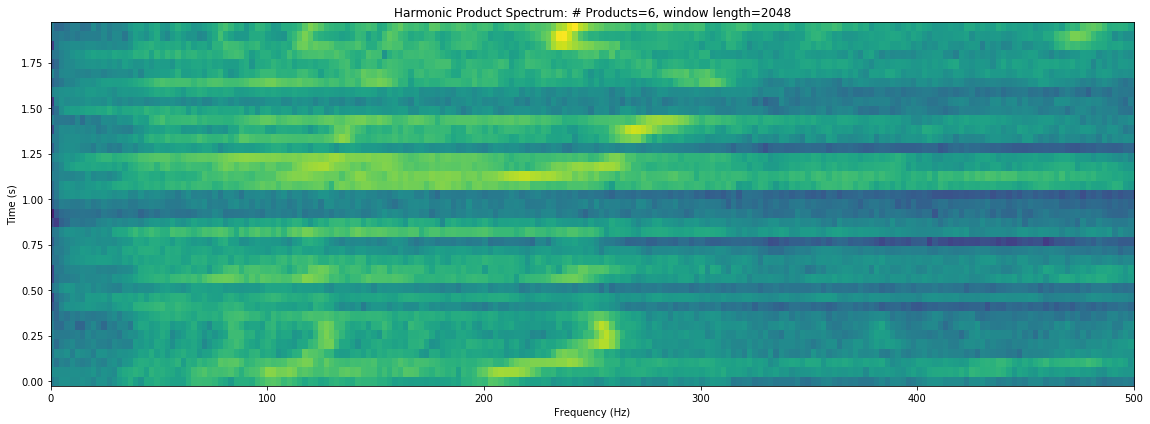

In [7]:
# Parameters for HPS and the sliding window over data to apply it over
prod = 6
winlen = 2*1024
overlap = winlen // 2
Nfft = int(4 * 2**np.ceil(np.log2(winlen)))

# Run HPS on winlen-long chunks of the data.
hpsArr = np.array(sliding(y, winlen, Noverlap=overlap,
                          f=lambda x: hps(x * hamming(len(x), False), prod, Nfft)[0]))
# Extract the frequency and time vectors that this array of spectra corresponds to
hpsF = hps(y[:winlen], prod, Nfft)[1] * fs
hpsT = np.arange(hpsArr.shape[0]) / fs * (winlen - overlap)

# Display
db20 = lambda x: np.log10(np.abs(x)) * 20

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]



plt.close()
plt.imshow(db20(hpsArr), aspect='auto', interpolation='nearest',
           extent=extents(hpsF) + extents(hpsT), cmap='viridis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (s)')
plt.title('Harmonic Product Spectrum: # Products={}, window length={}'.format(prod, winlen))
plt.tight_layout()
plt.xlim([0, 500])
plt.savefig('hps-0-500.png')



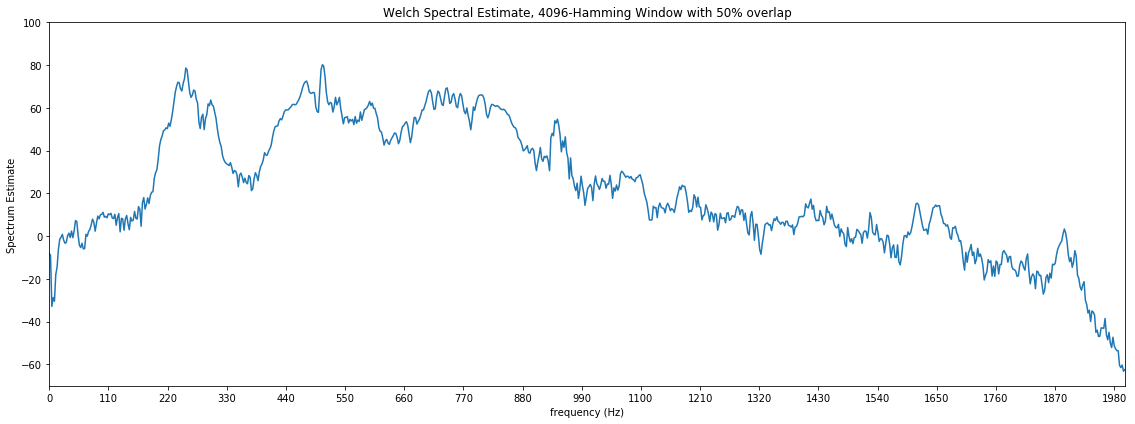

In [8]:
# No chunking
def nextpow2(n):
  return int(2 ** np.ceil(np.log2(n)))

prod = 6
[hpsS, hpsF] = hps(frame * hamming(len(frame)), prod, nextpow2(frame.size), fs)
plt.close()
plt.plot(hpsF, db20(hpsS))
plt.ylim([-100, 300])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectrum, dB')
plt.title('Harmonic Product Spectrum: # Products={}'.format(prod))
plt.tight_layout()

plt.gca().set_xticks(np.arange(0, 2000, 55))
plt.xlim([0, 1000])
plt.savefig('hps-alldata-0-1000.png')
plt.gca().set_xticks(np.arange(0, 2000, 110))
plt.xlim([0, 2000])
plt.savefig('hps-alldata-0-2000.png')


# Welch?
from scipy.signal import welch
(fWelch, pWelch) = welch(y, fs=fs, window='hamming', nperseg=8192, noverlap=4096)

plt.close()
plt.plot(fWelch, db20(pWelch))
plt.xlabel('frequency (Hz)')
plt.ylabel('Spectrum Estimate')
plt.title('Welch Spectral Estimate, 4096-Hamming Window with 50% overlap')

plt.ylim([-70, 100])
plt.xlim([0, 2000])
plt.tight_layout()
plt.gca().set_xticks(np.arange(0, 2000, 110))
plt.savefig('welch.png')


/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


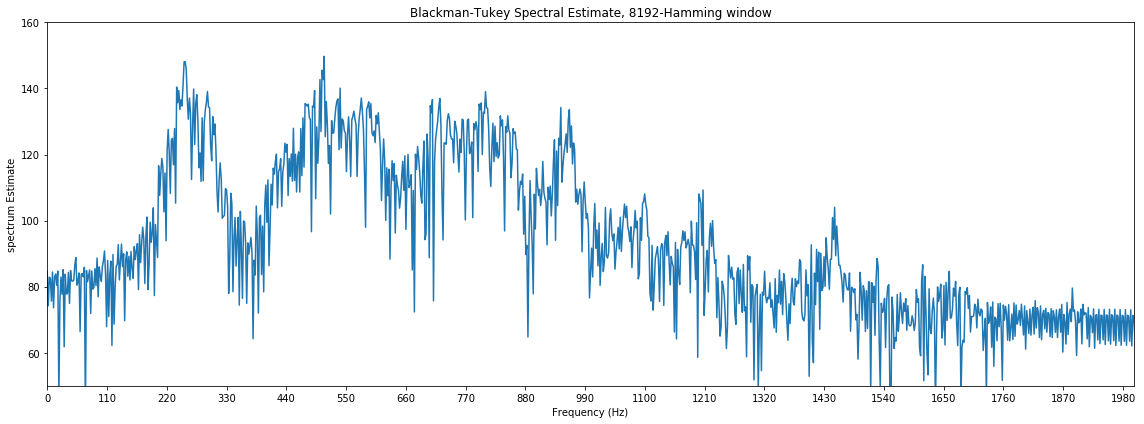

In [9]:

# Blackman-Tukey spectral esimator
from scipy.signal import correlate

def acorrBiased(y):
  """Obtain the biased autocorrelation and its lags
  """
  r = correlate(y, y) / len(y)
  l = np.arange(-(len(y)-1), len(y))
  return r,l

# This is a port of the code accompanying Stoica & Moses' "Spectral Analysis of
# Signals" (Pearson, 2005): http://www2.ece.ohio-state.edu/~randy/SAtext/
def blackmanTukey(y, w, Nfft, fs=1):
  M = len(w)
  N = len(y)
  if M>N:
    raise ValueError('Window cannot be longer than data')
  r, lags = acorrBiased(y)
  r = r[np.logical_and(lags >= 0, lags < M)]
  rw = r * w
  phi = 2 * fft.fft(rw, Nfft).real - rw[0];
  f = np.arange(Nfft) / Nfft;
  return (phi[f < 0.5], f[f < 0.5] * fs)


btWin = hamming(1024*8)
(pBT, fBT) = blackmanTukey(frame, btWin, 10*1024, fs)

plt.close()
plt.plot(fBT, db20(pBT))
plt.xlabel('Frequency (Hz)')
plt.ylabel('spectrum Estimate')
plt.title('Blackman-Tukey Spectral Estimate, {}-Hamming window'.format(btWin.size))

plt.gca().set_xticks(np.arange(0, 2000, 110))
plt.ylim([50, 160])
plt.xlim([0, 2000])

plt.tight_layout()

plt.savefig('btse.png')

In [10]:
m = max(pBT)
i = [i for i, j in enumerate(pBT) if j == m]
fBT[i[0]]

509.765625

In [11]:
pBT[0:400]

array([ 1.70720312e+04,  5.16305396e+03, -1.39026644e+04, -1.34104259e+04,
        6.04624852e+03,  1.66778292e+04,  4.80049520e+03, -1.41824978e+04,
       -1.55495464e+04,  1.04800764e+04,  1.72324546e+04, -2.20759539e+02,
       -6.34793299e+03, -1.40231083e+04,  7.71191632e+03,  1.80716568e+04,
        1.23278289e+03, -1.54805050e+04, -7.78614614e+03,  7.86938762e+03,
        1.64661607e+04,  5.57820212e+03, -1.75770508e+04, -1.22021162e+04,
        1.21295054e+04,  1.25028092e+04,  2.10685864e+04, -2.75983404e+04,
       -1.05524305e+04,  1.18259196e+04,  1.61562276e+04,  2.08840848e+03,
       -1.52607771e+04, -1.58206999e+04,  1.40939146e+04,  1.97179612e+04,
        1.32092154e+02, -1.75788671e+04, -1.18942185e+04,  1.46671690e+04,
        1.79442080e+04,  3.94504919e+03, -1.73060708e+04, -9.18652620e+03,
        9.71246664e+03,  1.87509527e+04,  1.03976186e+04, -2.71418444e+04,
       -7.03052987e+03,  1.99486615e+04,  1.44621960e+04,  1.20844828e+04,
       -2.01033951e+04, -

Text(0.5,1,'A frame')

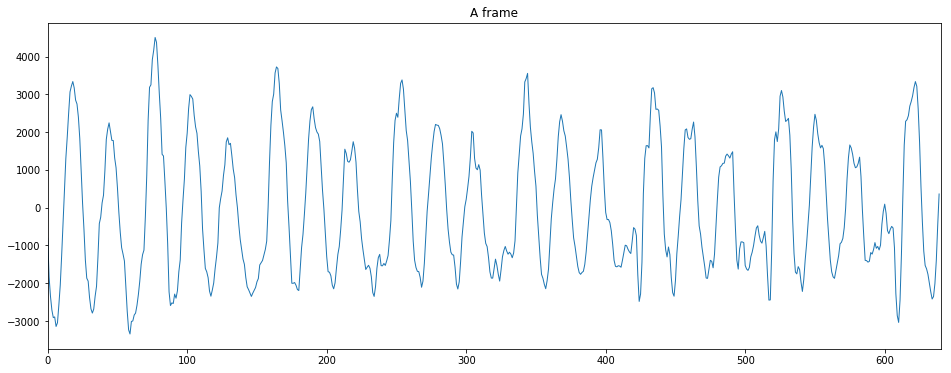

In [12]:
# Pick a short segment
windowlength = 32 # 32ms
ns_windowlength = int(round((windowlength * sfreq) / 1000))
pos = 31000
frame_length = ns_windowlength

frame = data[pos:pos+frame_length]

plot(frame, linewidth=1.0)
xlim(0, frame_length)
title("A frame")

### Calculate the autocorrelation using [scipy.signal.correlate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html) ###

/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


Text(0.5,1,'The complete autocorrelation')

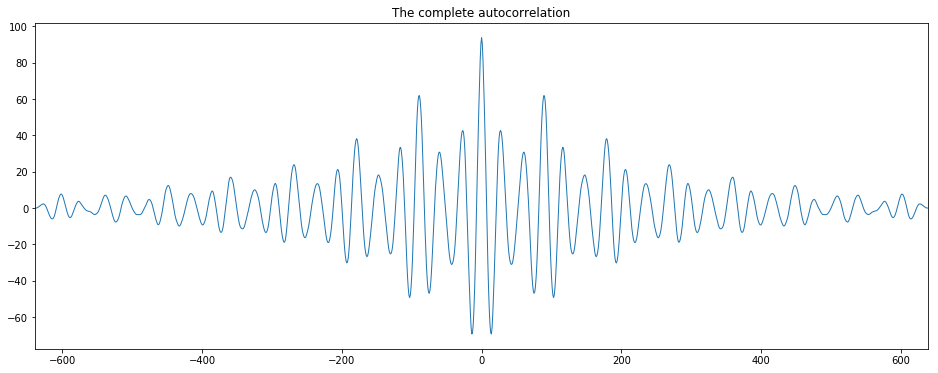

In [13]:
frame = frame.astype(np.float)
frame -= frame.mean()
amax = np.abs(frame).max()
frame /= amax
xlim(-(frame_length-1), frame_length-1)
bcorr = correlate(frame, frame)
plot(range(-(frame_length-1), frame_length), bcorr, linewidth=1.0)
title("The complete autocorrelation")

Text(0.5,1,'The autocorrelation for nonnegative indexes')

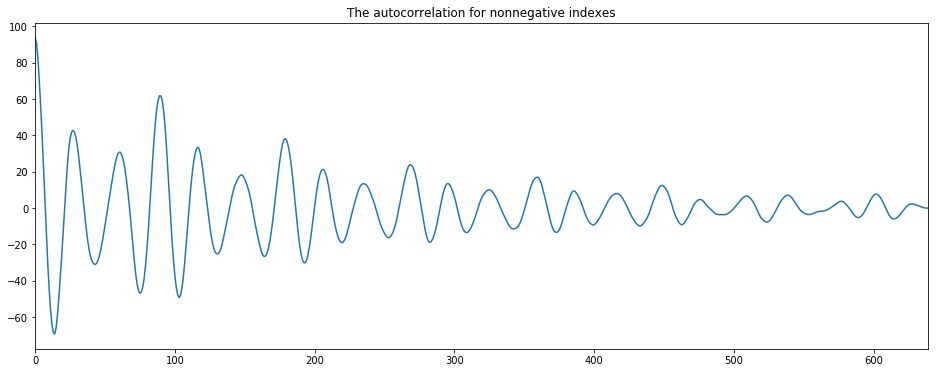

In [14]:
# keep the positive indexes of the autocorrelation
corr = bcorr[len(bcorr)//2:]
xlim(0, frame_length-1)
plot(corr)
title("The autocorrelation for nonnegative indexes")

### Caculate the first difference using [numpy.diff](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html) ###

Text(0.5,1,'The first difference of the autocorrelation (corr[n+1] - corr[n])')

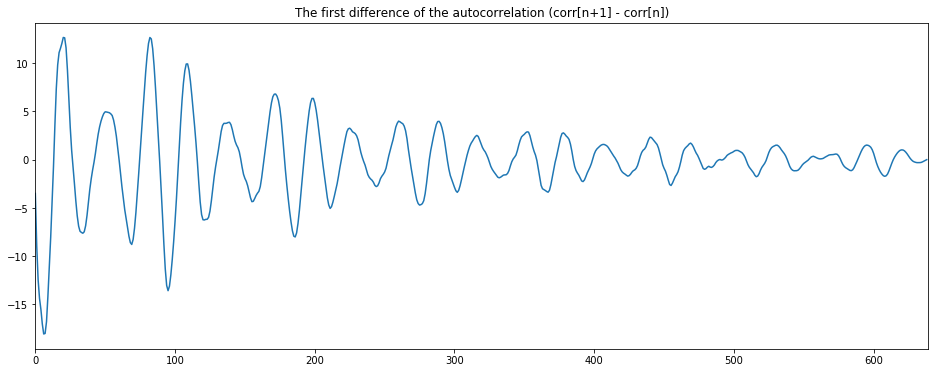

In [15]:
# Find the first minimum
dcorr = np.diff(corr)
xlim(0, len(dcorr))
plot(dcorr)
title("The first difference of the autocorrelation (corr[n+1] - corr[n])")

### Find the index of the first sample with positive difference using [numpy.where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) ###

Text(0.5,1,'Autocorrelation without the initial values up to the first minimum')

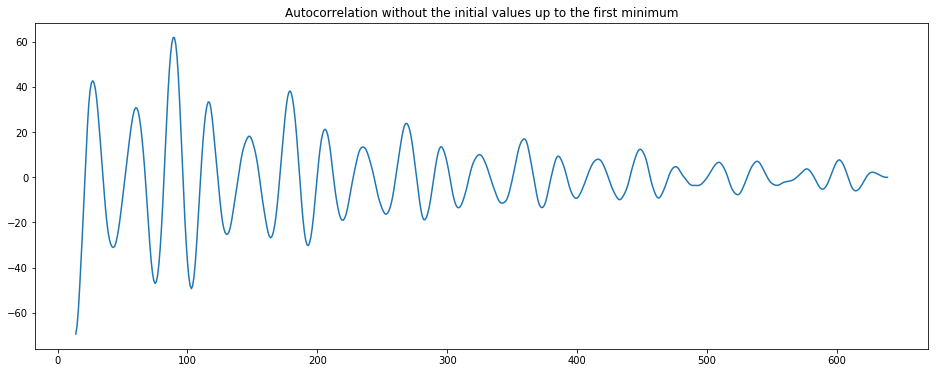

In [16]:
# Find the first minimum
rmin = np.where(dcorr > 0)[0]
if len(rmin) > 0:
    rmin1 = rmin[0]
plot(range(rmin1,len(corr)), corr[rmin1:])
title("Autocorrelation without the initial values up to the first minimum")

### Find the index of the sample with the maximum value using [numpy.argmax](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html) ###

In [17]:
# Find the next peak
peak = np.argmax(corr[rmin1:]) + rmin1
rmax = corr[peak]/corr[0]
f0 = sfreq / peak

In [18]:
print("corr[peak]/corr[0] = {:.1f}".format(rmax))
print("Pitch frequency = {:.1f} Hz".format(f0))
print("Pitch period {:.1f} ms ({:d} samples)".format((1/f0)*1000, peak))

corr[peak]/corr[0] = 0.7
Pitch frequency = 224.7 Hz
Pitch period 4.5 ms (89 samples)
